In [1]:
!pip install git+https://github.com/konstmish/opt_methods.git

  Cloning https://github.com/konstmish/opt_methods.git to /private/var/folders/1r/dhtw1ntj2klfnlqmdcmdbtcm71p3bh/T/pip-req-build-mlqqw3p7
  Created wheel for opt-methods: filename=opt_methods-0.1.1-py3-none-any.whl size=53038 sha256=ac5d3b242212025ab2c016991b7ece196820cd5f5e3bdcd7fe79e2cf8f1afda6
  Stored in directory: /private/var/folders/1r/dhtw1ntj2klfnlqmdcmdbtcm71p3bh/T/pip-ephem-wheel-cache-wc3ytv_y/wheels/bf/b4/48/3c91e0f1794f4eeba87acece649fcbd94f4b9a93674874633b
Successfully built opt-methods


In [2]:
!pip install -U ray

Requirement already up-to-date: ray in /opt/anaconda3/lib/python3.8/site-packages (1.13.0)


In [3]:
import matplotlib
import numpy as np
import psutil
import ray
import seaborn as sns

import matplotlib.pyplot as plt
import numpy.linalg as la
from scipy.sparse import csc_matrix, csr_matrix
from sklearn.datasets import load_svmlight_file, fetch_rcv1

from optmethods.datasets import get_dataset
from optmethods.first_order import Adgd, Gd, Nesterov, RestNest
from optmethods.loss import LogisticRegression
from optmethods.utils import get_trace, relative_round

sns.set(style="whitegrid", context="talk", font_scale=1.2, palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (9, 6)
# Multiple plots in one figure: code below
# import matplotlib.backends.backend_pdf as bf
# <code for plt>
# pdf = bf.PdfPages("./output.pdf")
# for fig in xrange(1, plt.figure().number):
#         pdf.savefig( fig )
# pdf.close()

In [4]:
num_cpus = psutil.cpu_count(logical=False)
# ray.init(num_cpus=num_cpus)

## Get data and define problem

In [7]:
import sklearn.datasets
import urllib.request
w8a_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a"
a9a_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a"
data_path = './w8a'
f = urllib.request.urlretrieve(w8a_url, data_path)
# f = urllib.request.urlretrieve(a9a_url, data_path)
A, b = sklearn.datasets.load_svmlight_file(data_path)

n, dim = A.shape
if n % num_cpus != 0:
    A = A[:n - (n % num_cpus)]
    b = b[:n - (n % num_cpus)]
b_unique = np.unique(b)
if (b_unique == [1, 2]).all():
    # Transform labels {1, 2} to {0, 1}
    b = b - 1
elif (b_unique == [-1, 1]).all():
    # Transform labels {-1, 1} to {0, 1}
    b = (b+1) / 2
else:
    # replace class labels with 0's and 1's
    b = 1. * (b == b[0])
# A = A.toarray()
l1 = 0
loss = LogisticRegression(A, b, l1=l1, l2=0)
n, dim = A.shape
if n <= 20000 or dim <= 20000:
    print('Computing the smoothness constant via SVD, it may take a few minutes...')
L = loss.smoothness
# l2 = 0
l2 = 1e-4 * L
loss.l2 = l2
# x0 = csc_matrix((dim, 1))
x0 = np.zeros(dim)
n_epoch = 100
# it_max = (n_epoch * n) // batch_size
trace_len = 300

print(L, l2)

Computing the smoothness constant via SVD, it may take a few minutes...
0.6611558746661758 6.611558746661757e-05


## Solve problem by Nesterov's method

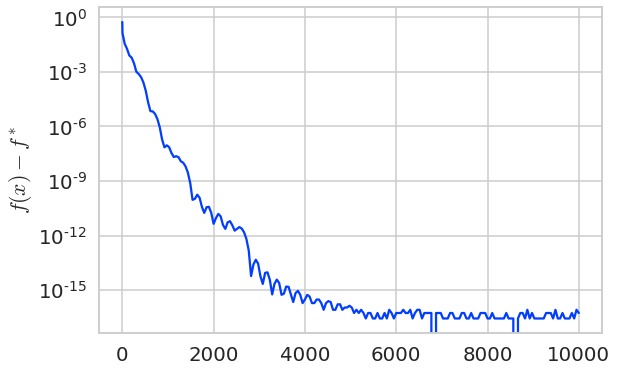

In [8]:
rest = RestNest(loss=loss, doubling=True)
rest_tr = rest.run(x0=x0, it_max=10000)
rest_tr.compute_loss_of_iterates()
rest.trace.plot_losses()
plt.yscale('log')

## Define local methods

### Local SGD

In [9]:
from optmethods.optimizer import StochasticOptimizer


@ray.remote
class Worker:
    def __init__(self, shuffle=True, prox_skip=False, loss=None, it_local=None, batch_size=1):
        self.loss = loss
        self.shuffle = shuffle
        self.prox_skip = prox_skip
        self.it_local = it_local
        self.batch_size = batch_size
        self.c = None
        self.h = None
        self.rng_skip = np.random.default_rng(42) # random number generator for random synchronizations
    
    def run_local(self, x, lr):
        self.x = x * 1.
        if self.shuffle:
            self.run_local_shuffle(lr)
        elif self.prox_skip:
            print(f"running prox skip with x={x}")
            self.run_prox_skip(lr)
        else:
            self.run_local_sgd(lr)
        return self.x
    
    def run_local_shuffle(self, lr):
        permutation = np.random.permutation(self.loss.n)
        i = 0
        while i < self.loss.n:
            i_max = min(self.loss.n, i + self.batch_size)
            idx = permutation[i:i_max]
            self.x -= lr * self.loss.stochastic_gradient(self.x, idx=idx)
            i += self.batch_size
    
    def run_local_sgd(self, lr):
        for i in range(self.it_local):
            if self.batch_size is None:
                self.x -= lr * self.loss.gradient(self.x)
            else:
                self.x -= lr * self.loss.stochastic_gradient(self.x, batch_size=self.batch_size)
    
    def run_scaffold(self, x, lr, c):
        # as in the original scaffold paper, we use their Option II
        self.x = x * 1.
        if self.c is None:
            self.c = self.x * 0. #initialize zero vector of the same dimension
        for i in range(self.it_local):
            if self.batch_size is None:
                g = self.loss.gradient(self.x)
            else:
                g = self.loss.stochastic_gradient(self.x, batch_size=self.batch_size)
            self.x -= lr * (g - self.c + c)
        self.c += 1 / (self.it_local * lr) * (x - self.x) - c
        return self.x

    def run_prox_skip(self, lr):
        p = 1 / self.it_local
        if self.h is None:
            # first iteration
            self.h = self.x * 0. # initialize zero vector of the same dimension
        else:
            # update the gradient estimate 
            self.h += p / self.lr * (self.x - self.x_before_averaing)
        it_local = self.rng_skip.geometric(p=p) # since all workers use the same random seed, this number is the same for all of them

        for i in range(it_local):
            if self.batch_size is None:
                g = self.loss.gradient(self.x)
            else:
                g = self.loss.stochastic_gradient(self.x, batch_size=self.batch_size)
            self.x -= lr * (g - self.h)
        self.x_before_averaing = self.x * 1.
    
    def get_control_var(self):
        return self.c


class LocalSgd(StochasticOptimizer):
    """
    Stochastic gradient descent with decreasing or constant learning rate.
    
    Arguments:
        lr (float, optional): an estimate of the inverse smoothness constant
        lr_decay_coef (float, optional): the coefficient in front of the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value
            is mu/2, where mu is the strong convexity constant
        lr_decay_power (float, optional): the power to exponentiate the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value is 1 (default: 1)
        it_start_decay (int, optional): how many iterations the step-size is kept constant
            By default, will be set to have about 2.5% of iterations with the step-size equal to lr0
        batch_size (int, optional): the number of samples from the function to be used at each iteration
    """
    def __init__(self, it_local, n_workers=None, cohort_size=None, iid=False, lr0=None, lr_max=np.inf, lr_decay_coef=0,
                 lr_decay_power=1, it_start_decay=None, batch_size=1, losses=None, *args, **kwargs):
        super(LocalSgd, self).__init__(*args, **kwargs)
        self.it_local = it_local
        if n_workers is None:
            n_workers = psutil.cpu_count(logical=False)
        if cohort_size is None:
            cohort_size = n_workers
        self.n_workers = n_workers
        self.cohort_size = cohort_size
        self.iid = iid
        self.lr0 = lr0
        self.lr_max = lr_max
        self.lr_decay_coef = lr_decay_coef
        self.lr_decay_power = lr_decay_power
        self.it_start_decay = it_start_decay
        self.batch_size = batch_size
        self.losses = losses
        
    def step(self):
        denom_const = 1 / self.lr0
        lr_decayed = 1 / (denom_const + self.it_local*self.lr_decay_coef*max(0, self.it-self.it_start_decay)**self.lr_decay_power)
        if lr_decayed < 0:
            lr_decayed = np.inf
        self.lr = min(lr_decayed, self.lr_max)
        x_id = ray.put(self.x)
        
        if self.cohort_size == self.n_workers:
            self.x = np.mean(ray.get([worker.run_local.remote(x_id, self.lr) for worker in self.workers]), axis=0)
        else:
            cohort = np.random.choice(self.n_workers, self.cohort_size, replace=False)
            self.x = np.mean(ray.get([self.workers[i].run_local.remote(x_id, self.lr) for i in cohort]), axis=0)
    
    def init_run(self, *args, **kwargs):
        super(LocalSgd, self).init_run(*args, **kwargs)
        if self.it_start_decay is None and np.isfinite(self.it_max):
            self.it_start_decay = self.it_max // 40 if np.isfinite(self.it_max) else 0
        if self.lr0 is None:
            self.lr0 = 1 / self.loss.batch_smoothness(batch_size)
        if self.iid:
            loss_id = ray.put(self.loss)
            self.workers = [Worker.remote(shuffle=False, loss=loss_id, it_local=self.it_local, batch_size=self.batch_size) for _ in range(self.n_workers)]
        else:
            loss_ids = [ray.put(self.losses[i]) for i in range(self.n_workers)]
            self.workers = [Worker.remote(shuffle=False, loss=loss, it_local=self.it_local, batch_size=self.batch_size) for loss in loss_ids]
        
    def update_trace(self, first_iterations=10):
        super(LocalSgd, self).update_trace()
        
    def terminate_workers(self):
        for worker in self.workers:
            ray.kill(worker)

### FedRR

In [10]:
import math

class LocalShuffling(StochasticOptimizer):
    """
    Shuffling-based stochastic gradient descent with decreasing or constant learning rate.
    For a formal description and convergence guarantees, see
        https://arxiv.org/abs/2006.05988
    
    The method is sensitive to finishing the final epoch, so it will terminate earlier 
    than it_max if it_max is not divisible by the number of steps per epoch.
    
    Arguments:
        reshuffle (bool, optional): whether to get a new permuation for every new epoch.
            For convex problems, only a single permutation should suffice and it can run faster (default: False)
        prox_every_it (bool, optional): whether to use proximal operation every iteration 
            or only at the end of an epoch. Theory supports the latter. Only used if the loss includes
            a proximal regularizer (default: False)
        lr0 (float, optional): an estimate of the inverse smoothness constant, this step-size
            is used for the first epoch_start_decay epochs. If not given, it will be set
            with the value in the loss.
        lr_max (float, optional): a maximal step-size never to be exceeded (default: np.inf)
        lr_decay_coef (float, optional): the coefficient in front of the number of finished epochs
            in the denominator of step-size. For strongly convex problems, a good value
            is mu/3, where mu is the strong convexity constant
        lr_decay_power (float, optional): the power to exponentiate the number of finished epochs
            in the denominator of step-size. For strongly convex problems, a good value is 1 (default: 1)
        epoch_start_decay (int, optional): how many epochs the step-size is kept constant
            By default, will be set to have about 2.5% of iterations with the step-size equal to lr0
        batch_size (int, optional): the number of samples from the function to be used at each iteration
    """
    def __init__(self, n_workers=None, iid=False, reshuffle=False, lr0=None, lr_max=np.inf, lr_decay_coef=0,
                 lr_decay_power=1, epoch_start_decay=1, batch_size=1, 
                 losses=None, jumping=0, cohort_size=None, *args, **kwargs):
        super(LocalShuffling, self).__init__(*args, **kwargs)
        if n_workers is None:
            n_workers = psutil.cpu_count(logical=False)
        if cohort_size is None:
            cohort_size = n_workers
        self.n_workers = n_workers
        self.cohort_size = cohort_size
        self.iid = iid
        self.reshuffle = reshuffle
        self.lr0 = lr0
        self.lr_max = lr_max
        self.lr_decay_coef = lr_decay_coef
        self.lr_decay_power = lr_decay_power
        self.epoch_start_decay = epoch_start_decay
        self.batch_size = batch_size
        self.losses = losses
        self.jumping = jumping
        
        if self.iid:
            self.steps_per_epoch = math.ceil(self.loss.n/batch_size)
        else:
            self.steps_per_epoch = math.ceil(self.loss.n/batch_size/n_workers)
        if epoch_start_decay is None and np.isfinite(self.epoch_max):
            self.epoch_start_decay = 1 + self.epoch_max // 40
        elif epoch_start_decay is None:
            self.epoch_start_decay = 1
        
    def step(self):
        if self.it%self.steps_per_epoch == 0 and self.reshuffle:
            # Start new epoch
            self.permutation = np.random.permutation(self.loss.n)
            self.i = 0
            self.sampled_permutations += 1
        idx_perm = np.arange(self.i, min(self.loss.n, self.i+self.batch_size))
        idx = self.permutation[idx_perm]
        self.i += self.batch_size
        # since the objective is 1/n sum_{i=1}^n f_i(x) + l2/2*||x||^2
        # any incomplete minibatch should be normalized by batch_size
        normalization = self.loss.n / self.steps_per_epoch
        self.grad = self.loss.stochastic_gradient(self.x, idx=idx, normalization=normalization)
        denom_const = 1 / self.lr0
        lr_decayed = 1 / (denom_const + self.loss.n/self.batch_size*self.lr_decay_coef*max(0, self.finished_epochs-self.epoch_start_decay)**self.lr_decay_power)
        self.lr = min(lr_decayed, self.lr_max)
        x_id = ray.put(self.x)
        if self.cohort_size == self.n_workers:
            x_new = np.mean(ray.get([worker.run_local.remote(x_id, self.lr) for worker in self.workers]), axis=0)
        else:
            cohort = np.random.choice(self.n_workers, self.cohort_size, replace=False)
            x_new = np.mean(ray.get([self.workers[i].run_local.remote(x_id, self.lr) for i in cohort]), axis=0)
        if self.jumping:
            full_grad_estim = (self.x - x_new) / self.lr
            self.gd_lr = self.lr * (1 + self.jumping)
            self.x = self.x - self.gd_lr * full_grad_estim
            self.jumping_sum += self.jumping_coef
        else:
            self.x = x_new
        self.finished_epochs += 1
    
    def init_run(self, *args, **kwargs):
        super(LocalShuffling, self).init_run(*args, **kwargs)
        if self.lr0 is None:
            self.lr0 = 1 / self.loss.batch_smoothness(batch_size)
        self.finished_epochs = 0
        self.permutation = np.random.permutation(self.loss.n)
        self.sampled_permutations = 1
        self.epoch_max = self.it_max // self.steps_per_epoch
        if self.iid:
            loss_id = ray.put(self.loss)
            self.workers = [Worker.remote(shuffle=True, loss=loss_id, it_local=None, batch_size=self.batch_size) for _ in range(self.n_workers)]
        else:
            loss_ids = [ray.put(self.losses[i]) for i in range(self.n_workers)]
            self.workers = [Worker.remote(shuffle=True, loss=loss, it_local=None, batch_size=self.batch_size) for loss in loss_ids]
        self.jumping_sum = 0
        self.gd_lr = None
        
    def terminate_workers(self):
        for worker in self.workers:
            ray.kill(worker)

### Scaffold

In [11]:
class Scaffold(StochasticOptimizer):
    """
    Scaffold (local SGD with variance control).
    
    Arguments:
        lr (float, optional): an estimate of the inverse smoothness constant
        lr_decay_coef (float, optional): the coefficient in front of the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value
            is mu/2, where mu is the strong convexity constant
        lr_decay_power (float, optional): the power to exponentiate the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value is 1 (default: 1)
        it_start_decay (int, optional): how many iterations the step-size is kept constant
            By default, will be set to have about 2.5% of iterations with the step-size equal to lr0
        batch_size (int, optional): the number of samples from the function to be used at each iteration
    """
    def __init__(self, it_local, n_workers=None, iid=False, lr0=None, lr_max=np.inf, 
                 lr_decay_coef=0, lr_decay_power=1, it_start_decay=None,
                 batch_size=1, losses=None, global_lr=1., cohort_size=None, *args, **kwargs):
        super(Scaffold, self).__init__(*args, **kwargs)
        self.it_local = it_local
        if n_workers is None:
            n_workers = psutil.cpu_count(logical=False)
        if cohort_size is None:
            cohort_size = n_workers
        self.n_workers = n_workers
        self.cohort_size = cohort_size
        self.iid = iid
        self.lr0 = lr0
        self.lr_max = lr_max
        self.lr_decay_coef = lr_decay_coef
        self.lr_decay_power = lr_decay_power
        self.it_start_decay = it_start_decay
        self.batch_size = batch_size
        self.losses = losses
        self.global_lr = global_lr
        self.trace.cs = []
        
    def step(self):
        denom_const = 1 / self.lr0
        lr_decayed = 1 / (denom_const + self.it_local*self.lr_decay_coef*max(0, self.it-self.it_start_decay)**self.lr_decay_power)
        if lr_decayed < 0:
            lr_decayed = np.inf 
        self.lr = min(lr_decayed, self.lr_max)
        x_id = ray.put(self.x)
        c_id = ray.put(self.c)
        if self.cohort_size == self.n_workers:
            x_new = np.mean(ray.get([worker.run_scaffold.remote(x_id, self.lr, c_id) for worker in self.workers]), axis=0)
            c_new = np.mean(ray.get([worker.get_control_var.remote() for worker in self.workers]), axis=0)
        else:
            cohort = np.random.choice(self.n_workers, self.cohort_size, replace=False)
            x_new = np.mean(ray.get([self.workers[i].run_scaffold.remote(x_id, self.lr, c_id) for i in cohort]), axis=0)
            c_new = np.mean(ray.get([self.workers[i].get_control_var.remote() for i in cohort]), axis=0)
        if self.global_lr == 1:
            self.x = x_new
        else:
            self.x += self.global_lr * (x_new - self.x)
        self.c += self.cohort_size / self.n_workers * (c_new - self.c)
    
    def init_run(self, *args, **kwargs):
        super(Scaffold, self).init_run(*args, **kwargs)
        if self.it_start_decay is None and np.isfinite(self.it_max):
            self.it_start_decay = self.it_max // 40 if np.isfinite(self.it_max) else 0
        self.c = self.x * 0
        if self.iid:
            loss_id = ray.put(self.loss)
            self.workers = [Worker.remote(shuffle=False, loss=loss_id, it_local=self.it_local, batch_size=self.batch_size) for _ in range(self.n_workers)]
        else:
            loss_ids = [ray.put(self.losses[i]) for i in range(self.n_workers)]
            self.workers = [Worker.remote(shuffle=False, loss=loss, it_local=self.it_local, batch_size=self.batch_size) for loss in loss_ids]
        
    def terminate_workers(self):
        for worker in self.workers:
            ray.kill(worker)
            
    def update_trace(self, first_iterations=10):
        super(Scaffold, self).update_trace()
        self.trace.cs.append(copy.deepcopy(self.c))


## FedLin

In [12]:
class Fedlin(StochasticOptimizer):
    """
    Fedlin (local SGD with variance control and linear convergence).
    
    Arguments:
        lr (float, optional): an estimate of the inverse smoothness constant
        lr_decay_coef (float, optional): the coefficient in front of the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value
            is mu/2, where mu is the strong convexity constant
        lr_decay_power (float, optional): the power to exponentiate the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value is 1 (default: 1)
        it_start_decay (int, optional): how many iterations the step-size is kept constant
            By default, will be set to have about 2.5% of iterations with the step-size equal to lr0
        batch_size (int, optional): the number of samples from the function to be used at each iteration
    """
    def __init__(self, it_local, n_workers=None, iid=False, lr0=None, lr_max=np.inf, 
                 lr_decay_coef=0, lr_decay_power=1, it_start_decay=None,
                 batch_size=1, losses=None, global_lr=1., cohort_size=None, *args, **kwargs):
        super(Fedlin, self).__init__(*args, **kwargs)
        self.it_local = it_local
        if n_workers is None:
            n_workers = psutil.cpu_count(logical=False)
        if cohort_size is None:
            cohort_size = n_workers
        self.n_workers = n_workers
        self.cohort_size = cohort_size
        self.iid = iid
        self.lr0 = lr0
        self.lr_max = lr_max
        self.lr_decay_coef = lr_decay_coef
        self.lr_decay_power = lr_decay_power
        self.it_start_decay = it_start_decay
        self.batch_size = batch_size
        self.losses = losses
        self.global_lr = global_lr
        self.g = None
        self.trace.gs = []
        
    def step(self):
        denom_const = 1 / self.lr0
        lr_decayed = 1 / (denom_const + self.it_local*self.lr_decay_coef*max(0, self.it-self.it_start_decay)**self.lr_decay_power)
        if lr_decayed < 0:
            lr_decayed = np.inf 
        self.lr = min(lr_decayed, self.lr_max)
        x_id = ray.put(self.x)
        if self.cohort_size != self.n_workers:
            raise ValueError("There is no theory for FedLin with partial participation. This feature is not implemented.")
            cohort = np.random.choice(self.n_workers, self.cohort_size, replace=False)
        g = np.mean(ray.get([worker.get_fedlin_grad.remote(x_id) for worker in self.workers]), axis=0)
        g_id = ray.put(g)
        if self.cohort_size == self.n_workers:
            self.x = np.mean(ray.get([worker.run_fedlin.remote(x_id, self.lr, g_id) for worker in self.workers]), axis=0)
            self.g = ray.get([worker.get_g.remote() for worker in self.workers])  
        else:
            self.x = np.mean(ray.get([self.workers[i].run_fedlin.remote(x_id, self.lr, c_id) for i in cohort]), axis=0)
            self.g = ray.get([worker.get_g.remote() for worker in self.workers])
    def init_run(self, *args, **kwargs):
        super(Fedlin, self).init_run(*args, **kwargs)
        if self.it_start_decay is None and np.isfinite(self.it_max):
            self.it_start_decay = self.it_max // 40 if np.isfinite(self.it_max) else 0
        if self.iid:
            loss_id = ray.put(self.loss)
            self.workers = [Worker.remote(shuffle=False, loss=loss_id, it_local=self.it_local, batch_size=self.batch_size) for _ in range(self.n_workers)]
        else:
            loss_ids = [ray.put(self.losses[i]) for i in range(self.n_workers)]
            self.workers = [Worker.remote(shuffle=False, loss=loss, it_local=self.it_local, batch_size=self.batch_size) for loss in loss_ids]
        
    def terminate_workers(self):
        for worker in self.workers:
            ray.kill(worker)
            
    def update_trace(self, first_iterations=10):
        super(Fedlin, self).update_trace()
        self.trace.gs.append(copy.deepcopy(self.g))
            
            


In [13]:
class S_local_GD(StochasticOptimizer):
    """
    S_local_GD (local SGD with variance control and linear convergence).
    
    Arguments:
        lr (float, optional): an estimate of the inverse smoothness constant
        lr_decay_coef (float, optional): the coefficient in front of the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value
            is mu/2, where mu is the strong convexity constant
        lr_decay_power (float, optional): the power to exponentiate the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value is 1 (default: 1)
        it_start_decay (int, optional): how many iterations the step-size is kept constant
            By default, will be set to have about 2.5% of iterations with the step-size equal to lr0
        batch_size (int, optional): the number of samples from the function to be used at each iteration
    """
    def __init__(self, it_local, n_workers=None, iid=False, lr0=None, lr_max=np.inf, 
                 lr_decay_coef=0, lr_decay_power=1, it_start_decay=None,
                 batch_size=1, losses=None, global_lr=1., cohort_size=None, *args, **kwargs):
        super(S_local_GD, self).__init__(*args, **kwargs)
        self.it_local = it_local
        if n_workers is None:
            n_workers = psutil.cpu_count(logical=False)
        if cohort_size is None:
            cohort_size = n_workers
        self.n_workers = n_workers
        self.cohort_size = cohort_size
        self.iid = iid
        self.lr0 = lr0
        self.lr_max = lr_max
        self.lr_decay_coef = lr_decay_coef
        self.lr_decay_power = lr_decay_power
        self.it_start_decay = it_start_decay
        self.batch_size = batch_size
        self.losses = losses
        self.global_lr = global_lr
        self.g = None
        self.trace.gs = []
        
    def step(self):
        denom_const = 1 / self.lr0
        lr_decayed = 1 / (denom_const + self.it_local*self.lr_decay_coef*max(0, self.it-self.it_start_decay)**self.lr_decay_power)
        if lr_decayed < 0:
            lr_decayed = np.inf 
        self.lr = min(lr_decayed, self.lr_max)
        x_id = ray.put(self.x)
        if self.cohort_size != self.n_workers:
            raise ValueError("There is no theory for FedLin with partial participation. This feature is not implemented.")
            cohort = np.random.choice(self.n_workers, self.cohort_size, replace=False)
        g = np.mean(ray.get([worker.get_fedlin_grad.remote(x_id) for worker in self.workers]), axis=0)
        g_id = ray.put(g)
        if self.cohort_size == self.n_workers:
            self.x = np.mean(ray.get([worker.run_slocalgd.remote(x_id, self.lr, g_id) for worker in self.workers]), axis=0)
            self.g = ray.get([worker.get_g.remote() for worker in self.workers])  
        else:
            self.x = np.mean(ray.get([self.workers[i].run_slocalgd.remote(x_id, self.lr, c_id) for i in cohort]), axis=0)
            self.g = ray.get([worker.get_g.remote() for worker in self.workers])
    def init_run(self, *args, **kwargs):
        super(S_local_GD, self).init_run(*args, **kwargs)
        if self.it_start_decay is None and np.isfinite(self.it_max):
            self.it_start_decay = self.it_max // 40 if np.isfinite(self.it_max) else 0
        if self.iid:
            loss_id = ray.put(self.loss)
            self.workers = [Worker.remote(shuffle=False, loss=loss_id, it_local=self.it_local, batch_size=self.batch_size) for _ in range(self.n_workers)]
        else:
            loss_ids = [ray.put(self.losses[i]) for i in range(self.n_workers)]
            self.workers = [Worker.remote(shuffle=False, loss=loss, it_local=self.it_local, batch_size=self.batch_size) for loss in loss_ids]
        
    def terminate_workers(self):
        for worker in self.workers:
            ray.kill(worker)
            
    def update_trace(self, first_iterations=10):
        super(S_local_GD, self).update_trace()
        self.trace.gs.append(copy.deepcopy(self.g))
            
            



# Non-iid

In [21]:
cohort_size = 20 # CHANGE IF YOU WANT PARTIAL PARTICIPATION
n_workers = 20
n_seeds = 1
batch_size = None

In [15]:
# permutation = A[:, 0].A.squeeze().argsort()
permutation = b.squeeze().argsort()

losses = []
idx = [0] + [(n * i) // n_workers for i in range(1, n_workers)] + [n]
for i in range(n_workers):
    idx_i = permutation[idx[i] : idx[i+1]]
    # idx_i = range(idx[i], idx[i + 1])
    loss_i = LogisticRegression(A[idx_i].A, b[idx_i], l1=0, l2=l2)
    loss_i.computed_grads = 0
    losses.append(loss_i)

/opt/anaconda3/lib/python3.8/site-packages/optmethods/loss/logistic_regression.py:44: UserWarning: The labels have only one unique value.
  warnings.warn('The labels have only one unique value.')


In [16]:
grad_norms = [np.linalg.norm(loss_i.gradient(loss.x_opt))**2 for loss_i in losses]
print(np.mean(grad_norms))

0.0027321010728551124


In [17]:
@ray.remote
class Worker:
    def __init__(self, shuffle=True, prox_skip=False, loss=None, it_local=None, batch_size=1):
        self.loss = loss
        self.shuffle = shuffle
        self.prox_skip = prox_skip
        self.it_local = it_local
        self.batch_size = batch_size
        self.c = None
        self.h = None
        self.rng_skip = np.random.default_rng(42) # random number generator for random synchronizations
    
    def run_local(self, x, lr):
        self.x = x * 1.
        if self.shuffle:
            self.run_local_shuffle(lr)
        elif self.prox_skip:
            self.run_prox_skip(lr)
        else:
            self.run_local_sgd(lr)
        return self.x
    
    def run_local_shuffle(self, lr):
        permutation = np.random.permutation(self.loss.n)
        i = 0
        while i < self.loss.n:
            i_max = min(self.loss.n, i + self.batch_size)
            idx = permutation[i:i_max]
            self.x -= lr * self.loss.stochastic_gradient(self.x, idx=idx)
            i += self.batch_size
    
    def run_local_sgd(self, lr):
        for i in range(self.it_local):
            if self.batch_size is None:
                self.x -= lr * self.loss.gradient(self.x)
            else:
                self.x -= lr * self.loss.stochastic_gradient(self.x, batch_size=self.batch_size)
    
    def run_scaffold(self, x, lr, c):
        # as in the original scaffold paper, we use their Option II
        self.x = x * 1.
        if self.c is None:
            self.c = self.x * 0. #initialize zero vector of the same dimension
        for i in range(self.it_local):
            if self.batch_size is None:
                g = self.loss.gradient(self.x)
            else:
                g = self.loss.stochastic_gradient(self.x, batch_size=self.batch_size)
            self.x -= lr * (g - self.c + c)
        self.c += 1 / (self.it_local * lr) * (x - self.x) - c
        return self.x

    def run_prox_skip(self, lr):
        p = 1 / self.it_local
        if self.h is None:
            # first iteration
            self.h = self.x * 0. # initialize zero vector of the same dimension
        else:
            # update the gradient estimate 
            self.h += p / lr * (self.x - self.x_before_averaing)
        it_local = self.rng_skip.geometric(p=p) # since all workers use the same random seed, this number is the same for all of them

        for i in range(it_local):
            if self.batch_size is None:
                g = self.loss.gradient(self.x)
            else:
                g = self.loss.stochastic_gradient(self.x, batch_size=self.batch_size)
            self.x -= lr * (g - self.h)
        self.x_before_averaing = self.x * 1.

    def run_fedlin(self, x, lr, g):
        self.x = x * 1.
        for i in range(self.it_local):
            if self.batch_size is None:
                grad = self.loss.gradient(self.x)
            else:
                grad = self.loss.stochastic_gradient(self.x, batch_size=self.batch_size)
            self.x -= lr * (grad - self.g + g)
        return self.x
    
    def run_slocalgd(self, x, lr, g):
        self.x = x * 1.
        p = 1 / self.it_local
        it_local = self.rng_skip.geometric(p=p)
        for i in range(self.it_local):
            if self.batch_size is None:
                grad = self.loss.gradient(self.x)
            else:
                grad = self.loss.stochastic_gradient(self.x, batch_size=self.batch_size)
            self.x -= lr * (grad - self.g + g)
        return self.x
    
    def get_control_var(self):
        return self.c
    
    def get_h(self):
        return self.h
    
    def get_g(self):
        return self.g
    
    def get_fedlin_grad(self, x):
        if self.batch_size is None:
            self.g = self.loss.gradient(x)
        else:
            self.g = self.loss.stochastic_gradient(x, batch_size=self.batch_size)
        return self.g

In [18]:
class ProxSkip(StochasticOptimizer):
    """
    Stochastic gradient descent with decreasing or constant learning rate.
    
    Arguments:
        lr (float, optional): an estimate of the inverse smoothness constant
        lr_decay_coef (float, optional): the coefficient in front of the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value
            is mu/2, where mu is the strong convexity constant
        lr_decay_power (float, optional): the power to exponentiate the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value is 1 (default: 1)
        it_start_decay (int, optional): how many iterations the step-size is kept constant
            By default, will be set to have about 2.5% of iterations with the step-size equal to lr0
        batch_size (int, optional): the number of samples from the function to be used at each iteration
    """
    def __init__(self, it_local, n_workers=None, cohort_size=None, iid=False, lr0=None, lr_max=np.inf, lr_decay_coef=0,
                 lr_decay_power=1, it_start_decay=None, batch_size=1, losses=None, *args, **kwargs):
        super(ProxSkip, self).__init__(*args, **kwargs)
        self.it_local = it_local
        if n_workers is None:
            n_workers = psutil.cpu_count(logical=False)
        if cohort_size is None:
            cohort_size = n_workers
        self.n_workers = n_workers
        self.cohort_size = cohort_size
        self.iid = iid
        self.lr0 = lr0
        self.lr_max = lr_max
        self.lr_decay_coef = lr_decay_coef
        self.lr_decay_power = lr_decay_power
        self.it_start_decay = it_start_decay
        self.batch_size = batch_size
        self.losses = losses
        self.trace.hs = []
        self.h = None
        
    def step(self):
        denom_const = 1 / self.lr0
        lr_decayed = 1 / (denom_const + self.it_local*self.lr_decay_coef*max(0, self.it-self.it_start_decay)**self.lr_decay_power)
        if lr_decayed < 0:
            lr_decayed = np.inf
        self.lr = min(lr_decayed, self.lr_max)
        x_id = ray.put(self.x)
        
        if self.cohort_size == self.n_workers:
            self.x = np.mean(ray.get([worker.run_local.remote(x_id, self.lr) for worker in self.workers]), axis=0)
        else:
            cohort = np.random.choice(self.n_workers, self.cohort_size, replace=False)
            self.x = np.mean(ray.get([self.workers[i].run_local.remote(x_id, self.lr) for i in cohort]), axis=0)
    
    def init_run(self, *args, **kwargs):
        super(ProxSkip, self).init_run(*args, **kwargs)
        if self.it_start_decay is None and np.isfinite(self.it_max):
            self.it_start_decay = self.it_max // 40 if np.isfinite(self.it_max) else 0
        if self.lr0 is None:
            self.lr0 = 1 / self.loss.batch_smoothness(batch_size)
        if self.iid:
            loss_id = ray.put(self.loss)
            self.workers = [Worker.remote(shuffle=False, prox_skip=True, loss=loss_id, it_local=self.it_local, batch_size=self.batch_size) for _ in range(self.n_workers)]
        else:
            loss_ids = [ray.put(self.losses[i]) for i in range(self.n_workers)]
            self.workers = [Worker.remote(shuffle=False, prox_skip=True, loss=loss, it_local=self.it_local, batch_size=self.batch_size) for loss in loss_ids]
        
    def update_trace(self, first_iterations=10):
        super(ProxSkip, self).update_trace()
        self.trace.hs.append(copy.deepcopy(h))
        
    def terminate_workers(self):
        for worker in self.workers:
            ray.kill(worker)

In [19]:
loss.smoothness

0.6611558746661758

In [20]:
class ProxSkip(StochasticOptimizer):
    """
    Stochastic gradient descent with decreasing or constant learning rate.
    
    Arguments:
        lr (float, optional): an estimate of the inverse smoothness constant
        lr_decay_coef (float, optional): the coefficient in front of the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value
            is mu/2, where mu is the strong convexity constant
        lr_decay_power (float, optional): the power to exponentiate the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value is 1 (default: 1)
        it_start_decay (int, optional): how many iterations the step-size is kept constant
            By default, will be set to have about 2.5% of iterations with the step-size equal to lr0
        batch_size (int, optional): the number of samples from the function to be used at each iteration
    """
    def __init__(self, it_local, n_workers=None, cohort_size=None, iid=False, lr0=None, lr_max=np.inf, lr_decay_coef=0,
                 lr_decay_power=1, it_start_decay=None, batch_size=1, losses=None, *args, **kwargs):
        super(ProxSkip, self).__init__(*args, **kwargs)
        self.it_local = it_local
        if n_workers is None:
            n_workers = psutil.cpu_count(logical=False)
        if cohort_size is None:
            cohort_size = n_workers
        self.n_workers = n_workers
        self.cohort_size = cohort_size
        self.iid = iid
        self.lr0 = lr0
        self.lr_max = lr_max
        self.lr_decay_coef = lr_decay_coef
        self.lr_decay_power = lr_decay_power
        self.it_start_decay = it_start_decay
        self.batch_size = batch_size
        self.losses = losses
        self.trace.hs = []
        
        

             
    def step(self):
        denom_const = 1 / self.lr0
        lr_decayed = 1 / (denom_const + self.it_local*self.lr_decay_coef*max(0, self.it-self.it_start_decay)**self.lr_decay_power)
        if lr_decayed < 0:
            lr_decayed = np.inf
        self.lr = min(lr_decayed, self.lr_max)
        x_id = ray.put(self.x)
        
        if self.cohort_size == self.n_workers:
            self.x = np.mean(ray.get([worker.run_local.remote(x_id, self.lr) for worker in self.workers]), axis=0)
            self.h = ray.get([worker.get_h.remote() for worker in self.workers])       
        else:
            cohort = np.random.choice(self.n_workers, self.cohort_size, replace=False)
            self.x = np.mean(ray.get([self.workers[i].run_local.remote(x_id, self.lr) for i in cohort]), axis=0)
            self.h = ray.get([worker.get_h.remote() for worker in self.workers])       
    
    def init_run(self, *args, **kwargs):
        super(ProxSkip, self).init_run(*args, **kwargs)
        if self.it_start_decay is None and np.isfinite(self.it_max):
            self.it_start_decay = self.it_max // 40 if np.isfinite(self.it_max) else 0
        if self.lr0 is None:
            self.lr0 = 1 / self.loss.batch_smoothness(batch_size)
        if self.iid:
            loss_id = ray.put(self.loss)
            self.workers = [Worker.remote(shuffle=False, prox_skip=True, loss=loss_id, it_local=self.it_local, batch_size=self.batch_size) for _ in range(self.n_workers)]
        else:
            loss_ids = [ray.put(self.losses[i]) for i in range(self.n_workers)]
            self.workers = [Worker.remote(shuffle=False, prox_skip=True, loss=loss, it_local=self.it_local, batch_size=self.batch_size) for loss in loss_ids]
        
    def update_trace(self, first_iterations=10):
        super(ProxSkip, self).update_trace()
        self.trace.hs.append(copy.deepcopy(self.h))
        
    def terminate_workers(self):
        for worker in self.workers:
            ray.kill(worker)

In [22]:
if batch_size is not None:
    it_local = 100
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
    it_max = 2000
    skip_decay_coef = l2 / 2
else:
    it_local = 100 # same as for other methods
    skip_lr0 = 1 / (loss.smoothness)
    it_max = 2000 # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize



In [27]:
import copy

In [28]:
skip_lr_max = skip_lr0
skip = ProxSkip(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
skip.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
skip.trace.compute_loss_of_iterates()
skip.terminate_workers()

2022-06-17 04:04:24,484	WARNING worker.py:1404 -- WARNING: 34 PYTHON worker processes have been started on node: 4398c13e6d79dc3a2d529cca302f7602b02912d6181290ba36d95473 with address: 127.0.0.1. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


In [29]:
if batch_size is not None:
    it_local = 100
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
    it_max = 2000
    skip_decay_coef = l2 / 2
else:
    it_local = 100 # same as for other methods
    skip_lr0 = 1 / (loss.smoothness*it_local)
    it_max =2000 # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize

skip_lr_max = skip_lr0
fedlin1 = Fedlin(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
fedlin1.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
fedlin1.trace.compute_loss_of_iterates()
fedlin1.terminate_workers()

In [30]:
if batch_size is not None:
    it_local = 100
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
    it_max = 2000
    skip_decay_coef = l2 / 2
else:
    it_local = 100 # same as for other methods
    skip_lr0 = 1 / (loss.smoothness*it_local)
    it_max = 2000 # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize

skip_lr_max = skip_lr0
scaf = Scaffold(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
scaf.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
scaf.trace.compute_loss_of_iterates()
scaf.terminate_workers()

In [31]:
if batch_size is not None:
    it_local = 100
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
    it_max = 2000
    skip_decay_coef = l2 / 2
else:
    it_local = 100 # same as for other methods
    skip_lr0 = 1 / (loss.smoothness*it_local)
    it_max =2000 # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize

skip_lr_max = skip_lr0
slocalgd = S_local_GD(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
slocalgd.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
slocalgd.trace.compute_loss_of_iterates()
slocalgd.terminate_workers()

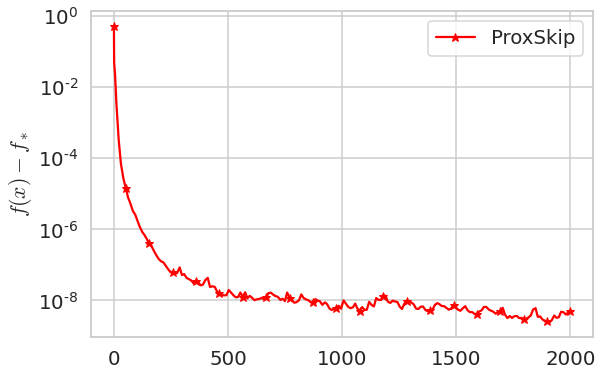

In [55]:
skip.trace.plot_losses(label='ProxSkip', marker='*', color='red')
plt.yscale('log')
plt.ylabel(r'$f(x)-f_*$')
plt.legend()

In [61]:
cohort_size = 15 # CHANGE IF YOU WANT PARTIAL PARTICIPATION
n_workers = 15
n_seeds = 1
batch_size = 2000

In [62]:
# permutation = A[:, 0].A.squeeze().argsort()
permutation = b.squeeze().argsort()

losses = []
idx = [0] + [(n * i) // n_workers for i in range(1, n_workers)] + [n]
for i in range(n_workers):
    idx_i = permutation[idx[i] : idx[i+1]]
    # idx_i = range(idx[i], idx[i + 1])
    loss_i = LogisticRegression(A[idx_i].A, b[idx_i], l1=0, l2=l2)
    loss_i.computed_grads = 0
    losses.append(loss_i)

/opt/anaconda3/lib/python3.8/site-packages/optmethods/loss/logistic_regression.py:44: UserWarning: The labels have only one unique value.
  warnings.warn('The labels have only one unique value.')


In [63]:
if batch_size is not None:
    it_local = 100
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
    it_max = 2000
    skip_decay_coef = l2 / 2
else:
    it_local = 30 # same as for other methods
    skip_lr0 = 1 / (loss.smoothness)
    it_max = 300 # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize

skip_lr_max = skip_lr0
skip1 = ProxSkip(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
skip1.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
skip1.trace.compute_loss_of_iterates()
skip1.terminate_workers()

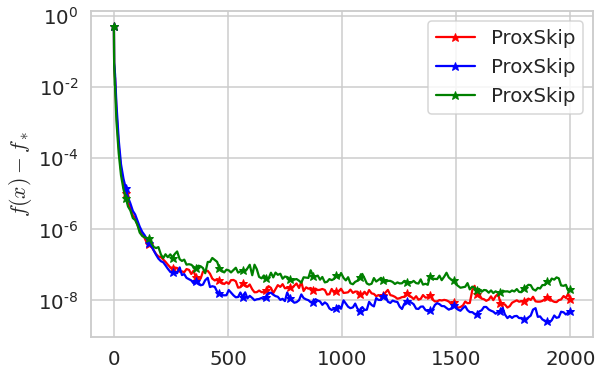

In [69]:
skip1.trace.plot_losses(label='ProxSkip', marker='*', color='red')
skip.trace.plot_losses(label='ProxSkip', marker='*', color='blue')
skip2.trace.plot_losses(label='ProxSkip', marker='*', color='green')
plt.yscale('log')
plt.ylabel(r'$f(x)-f_*$')
plt.legend()

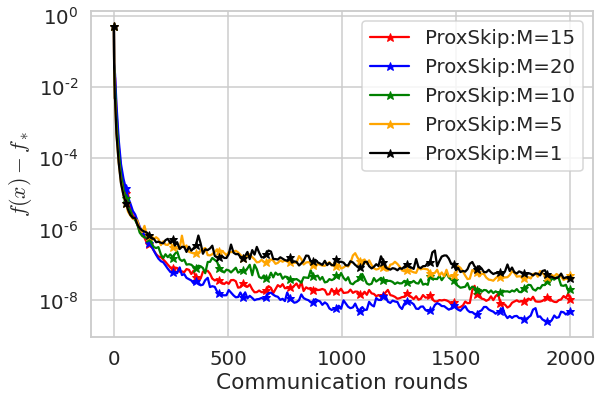

In [79]:
skip1.trace.plot_losses(label='ProxSkip:M=15', marker='*', color='red')
skip.trace.plot_losses(label='ProxSkip:M=20', marker='*', color='blue')
skip2.trace.plot_losses(label='ProxSkip:M=10', marker='*', color='green')
skip3.trace.plot_losses(label='ProxSkip:M=5', marker='*', color='orange')
skip4.trace.plot_losses(label='ProxSkip:M=1', marker='*', color='black')
plt.yscale('log')
plt.ylabel(r'$f(x)-f_*$')
plt.xlabel('Communication rounds')
plt.legend()
plt.savefig('linear_speedup.pdf')

In [172]:
cohort_size = 40 # CHANGE IF YOU WANT PARTIAL PARTICIPATION
n_workers = 40
n_seeds = 1
batch_size = 2000
permutation = b.squeeze().argsort()

losses = []
idx = [0] + [(n * i) // n_workers for i in range(1, n_workers)] + [n]
for i in range(n_workers):
    idx_i = permutation[idx[i] : idx[i+1]]
    # idx_i = range(idx[i], idx[i + 1])
    loss_i = LogisticRegression(A[idx_i].A, b[idx_i], l1=0, l2=l2)
    loss_i.computed_grads = 0
    losses.append(loss_i)

In [173]:
if batch_size is not None:
    it_local = 100
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
    it_max = 2000
    skip_decay_coef = l2 / 2
else:
    it_local = 30 # same as for other methods
    skip_lr0 = 1 / (loss.smoothness)
    it_max = 300 # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize

skip_lr_max = skip_lr0
skip50 = ProxSkip(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
skip50.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
skip50.trace.compute_loss_of_iterates()
skip50.terminate_workers()

2022-06-17 03:39:49,658	WARNING worker.py:1404 -- WARNING: 60 PYTHON worker processes have been started on node: 17da99a218cc3f339ea40b8647df58a1ca375757f60d4ac77fc1622d with address: 127.0.0.1. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-06-17 03:39:53,692	WARNING worker.py:1404 -- WARNING: 64 PYTHON worker processes have been started on node: 17da99a218cc3f339ea40b8647df58a1ca375757f60d4ac77fc1622d with address: 127.0.0.1. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


RayTaskError(ValueError): [36mray::Worker.run_local()[39m (pid=38503, ip=127.0.0.1, repr=<__main__.Worker object at 0x7fdf783173d0>)
  File "<ipython-input-156-f9ff1b5011f8>", line 18, in run_local
  File "<ipython-input-156-f9ff1b5011f8>", line 67, in run_prox_skip
  File "/opt/anaconda3/lib/python3.8/site-packages/optmethods/loss/logistic_regression.py", line 112, in stochastic_gradient
    idx = np.random.choice(self.n, size=batch_size, replace=replace, p=p)
  File "mtrand.pyx", line 954, in numpy.random.mtrand.RandomState.choice
ValueError: Cannot take a larger sample than population when 'replace=False'

2022-06-17 03:39:58,190	WARNING worker.py:1404 -- WARNING: 74 PYTHON worker processes have been started on node: 17da99a218cc3f339ea40b8647df58a1ca375757f60d4ac77fc1622d with address: 127.0.0.1. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-06-17 03:40:00,877	ERROR worker.py:94 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::Worker.run_local() (pid=38501, ip=127.0.0.1, repr=<__main__.Worker object at 0x7f99104bf3d0>)
  File "<ipython-input-156-f9ff1b5011f8>", line 18, in run_local
  File "<ipython-input-156-f9ff1b5011f8>", line 67, in run_prox_skip
  File "/opt/anaconda3/lib/python3.8/site-packages/optmethods/loss/logistic_regression.py", line 112, in stochastic_gradient
    idx = np.random.choice(self.n, size=batch_size, replace=replace, p=p)
  File "mtrand.pyx", line 954, in numpy.random.mtrand.RandomState.choice

2022-06-17 03:40:05,887	ERROR worker.py:94 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::Worker.run_local() (pid=38514, ip=127.0.0.1, repr=<__main__.Worker object at 0x7f9a5850f400>)
  File "<ipython-input-156-f9ff1b5011f8>", line 18, in run_local
  File "<ipython-input-156-f9ff1b5011f8>", line 67, in run_prox_skip
  File "/opt/anaconda3/lib/python3.8/site-packages/optmethods/loss/logistic_regression.py", line 112, in stochastic_gradient
    idx = np.random.choice(self.n, size=batch_size, replace=replace, p=p)
  File "mtrand.pyx", line 954, in numpy.random.mtrand.RandomState.choice
ValueError: Cannot take a larger sample than population when 'replace=False'
2022-06-17 03:40:05,888	ERROR worker.py:94 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::Worker.run_local() (pid=38518, ip=127.0.0.1, repr=<__main__.Worker object at 0x7fa9483383a0>)
  File "<ipython-input-156-f9ff1b5011f8>", line 18, in run_local
  File "<ipython-input-156-f9ff1

In [66]:
cohort_size = 10 # CHANGE IF YOU WANT PARTIAL PARTICIPATION
n_workers = 10
n_seeds = 1
batch_size = 2000

In [67]:
# permutation = A[:, 0].A.squeeze().argsort()
permutation = b.squeeze().argsort()

losses = []
idx = [0] + [(n * i) // n_workers for i in range(1, n_workers)] + [n]
for i in range(n_workers):
    idx_i = permutation[idx[i] : idx[i+1]]
    # idx_i = range(idx[i], idx[i + 1])
    loss_i = LogisticRegression(A[idx_i].A, b[idx_i], l1=0, l2=l2)
    loss_i.computed_grads = 0
    losses.append(loss_i)

/opt/anaconda3/lib/python3.8/site-packages/optmethods/loss/logistic_regression.py:44: UserWarning: The labels have only one unique value.
  warnings.warn('The labels have only one unique value.')


In [68]:
if batch_size is not None:
    it_local = 100
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
    it_max = 2000
    skip_decay_coef = l2 / 2
else:
    it_local = 30 # same as for other methods
    skip_lr0 = 1 / (loss.smoothness)
    it_max = 300 # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize

skip_lr_max = skip_lr0
skip2 = ProxSkip(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
skip2.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
skip2.trace.compute_loss_of_iterates()
skip2.terminate_workers()

In [71]:
cohort_size = 5 # CHANGE IF YOU WANT PARTIAL PARTICIPATION
n_workers = 5
n_seeds = 1
batch_size = 2000

In [72]:
# permutation = A[:, 0].A.squeeze().argsort()
permutation = b.squeeze().argsort()

losses = []
idx = [0] + [(n * i) // n_workers for i in range(1, n_workers)] + [n]
for i in range(n_workers):
    idx_i = permutation[idx[i] : idx[i+1]]
    # idx_i = range(idx[i], idx[i + 1])
    loss_i = LogisticRegression(A[idx_i].A, b[idx_i], l1=0, l2=l2)
    loss_i.computed_grads = 0
    losses.append(loss_i)

/opt/anaconda3/lib/python3.8/site-packages/optmethods/loss/logistic_regression.py:44: UserWarning: The labels have only one unique value.
  warnings.warn('The labels have only one unique value.')


In [73]:
if batch_size is not None:
    it_local = 100
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
    it_max = 2000
    skip_decay_coef = l2 / 2
else:
    it_local = 30 # same as for other methods
    skip_lr0 = 1 / (loss.smoothness)
    it_max = 300 # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize

skip_lr_max = skip_lr0
skip3 = ProxSkip(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
skip3.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
skip3.trace.compute_loss_of_iterates()
skip3.terminate_workers()

In [ ]:
cohort_size = 1 # CHANGE IF YOU WANT PARTIAL PARTICIPATION
n_workers = 1
n_seeds = 1
batch_size = 2000

In [75]:
# permutation = A[:, 0].A.squeeze().argsort()
permutation = b.squeeze().argsort()

losses = []
idx = [0] + [(n * i) // n_workers for i in range(1, n_workers)] + [n]
for i in range(n_workers):
    idx_i = permutation[idx[i] : idx[i+1]]
    # idx_i = range(idx[i], idx[i + 1])
    loss_i = LogisticRegression(A[idx_i].A, b[idx_i], l1=0, l2=l2)
    loss_i.computed_grads = 0
    losses.append(loss_i)

/opt/anaconda3/lib/python3.8/site-packages/optmethods/loss/logistic_regression.py:44: UserWarning: The labels have only one unique value.
  warnings.warn('The labels have only one unique value.')


In [76]:
if batch_size is not None:
    it_local = 100
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
    it_max = 2000
    skip_decay_coef = l2 / 2
else:
    it_local = 30 # same as for other methods
    skip_lr0 = 1 / (loss.smoothness)
    it_max = 300 # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize

skip_lr_max = skip_lr0
skip4 = ProxSkip(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
skip4.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
skip4.trace.compute_loss_of_iterates()
skip4.terminate_workers()

In [106]:
if batch_size is not None:
    it_local = 100
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
    it_max = 2000
    skip_decay_coef = l2 / 2
else:
    it_local = 30 # same as for other methods
    skip_lr0 = 1 / (loss.smoothness)
    it_max = 300 # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize

skip_lr_max = skip_lr0
skip_ = ProxSkip(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
skip_.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
skip_.trace.compute_loss_of_iterates()
skip_.terminate_workers()

In [91]:
import copy

In [51]:
norms_hs = []
for i in range(len(skip.trace.hs)):
    norms_hs.append(np.linalg.norm(np.array(skip.trace.hs[i]) - np.array(h_opt)))

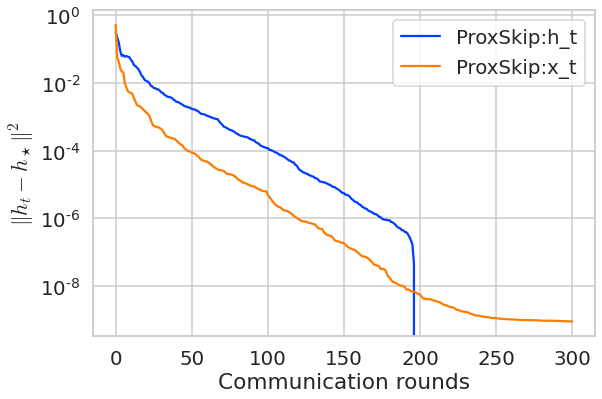

In [124]:
plt.plot(norms_hs,label = 'ProxSkip:h_t')
skip_.trace.plot_losses(label='ProxSkip:x_t')
plt.yscale('log')
plt.ylabel(r'$\Vert h_t - h_\star \Vert^2$')
plt.xlabel('Communication rounds')
plt.legend()

In [125]:
len(skip_.trace.hs)

198

In [139]:
if batch_size is not None:
    it_local = 100
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
    it_max = 2000
    skip_decay_coef = l2 / 2
else:
    it_local = 30 # same as for other methods
    skip_lr0 = 1 / (loss.smoothness)
    it_max = 300 # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize

skip_lr_max = skip_lr0
fedlin1 = Fedlin(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
fedlin1.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
fedlin1.trace.compute_loss_of_iterates()
fedlin1.terminate_workers()

(raylet) Spilled 4128 MiB, 828 objects, write throughput 303 MiB/s.


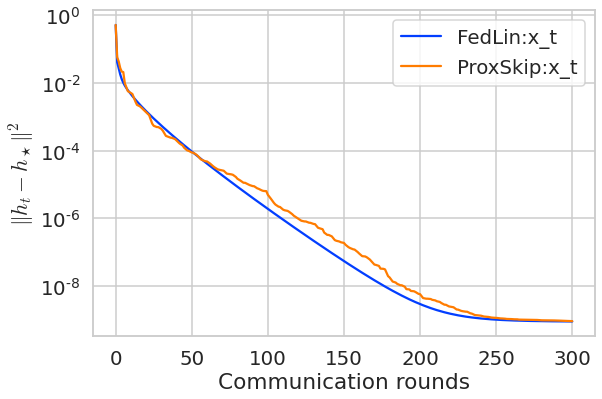

In [142]:
fedlin1.trace.plot_losses(label='FedLin:x_t')
skip_.trace.plot_losses(label='ProxSkip:x_t')
plt.yscale('log')
plt.ylabel(r'$\Vert h_t - h_\star \Vert^2$')
plt.xlabel('Communication rounds')
plt.legend()

In [49]:
norms_gs = []
for i in range(len(fedlin1.trace.gs)):
    norms_gs.append(np.linalg.norm(np.array(fedlin1.trace.gs[i]) - np.array(h_opt)))

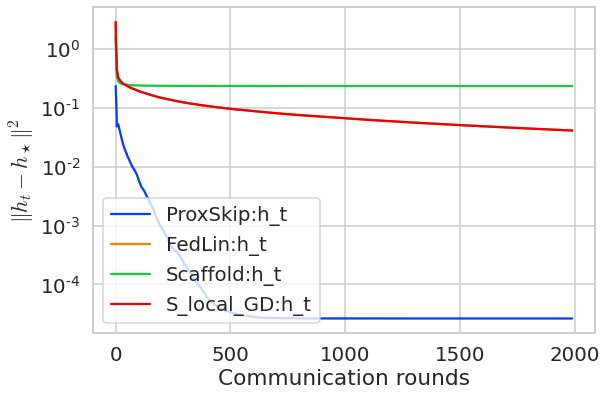

In [58]:
plt.plot(skip.trace.its[:-1],norms_hs,label = 'ProxSkip:h_t')
plt.plot(skip.trace.its[:-1],norms_gs,label = 'FedLin:h_t')
plt.plot(skip.trace.its[:-1],norms_cs,label = 'Scaffold:h_t')
plt.plot(skip.trace.its[:-1],norms_sgs,label = 'S_local_GD:h_t')
plt.yscale('log')
plt.ylabel(r'$\Vert h_t - h_\star \Vert^2$')
plt.xlabel('Communication rounds')
plt.legend()

In [153]:
if batch_size is not None:
    it_local = 100
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
    it_max = 2000
    skip_decay_coef = l2 / 2
else:
    it_local = 30 # same as for other methods
    skip_lr0 = 1 / (loss.smoothness)
    it_max = 300 # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize

skip_lr_max = skip_lr0
scaf = Scaffold(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
scaf.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
scaf.trace.compute_loss_of_iterates()
scaf.terminate_workers()

In [47]:
norms_cs = []
for i in range(len(scaf.trace.cs)):
    norms_cs.append(np.linalg.norm(np.array(scaf.trace.cs[i]) - np.array(h_opt)))

In [166]:
if batch_size is not None:
    it_local = 100
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
    it_max = 2000
    skip_decay_coef = l2 / 2
else:
    it_local = 30 # same as for other methods
    skip_lr0 = 1 / (loss.smoothness)
    it_max = 300 # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize

skip_lr_max = skip_lr0
slocalgd = S_local_GD(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
slocalgd.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
slocalgd.trace.compute_loss_of_iterates()
slocalgd.terminate_workers()






In [50]:
norms_sgs = []
for i in range(len(slocalgd.trace.gs)):
    norms_sgs.append(np.linalg.norm(np.array(slocalgd.trace.gs[i]) - np.array(h_opt)))

AttributeError: 'StochasticTrace' object has no attribute 'cs'

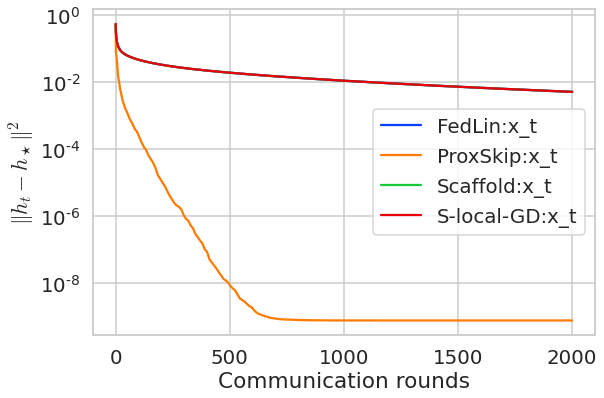

In [35]:
fedlin1.trace.plot_losses(label='FedLin:x_t')
skip.trace.plot_losses(label='ProxSkip:x_t')
scaf.trace.plot_losses(label='Scaffold:x_t')
slocalgd.trace.plot_losses(label='S-local-GD:x_t')
plt.yscale('log')
plt.ylabel(r'$\Vert h_t - h_\star \Vert^2$')
plt.xlabel('Communication rounds')
plt.legend()

In [45]:
rest.trace.xs[-1]

array([-1.40465678, -1.51411052, -1.59943481, -1.52690575, -2.1504606 ,
       -0.80485928, -0.91697642, -0.533643  , -0.74637403, -1.59993114,
       -1.47996884, -0.82345204, -0.49678069, -0.86064287, -0.72931136,
       -2.05514232, -0.45265727, -0.85577994, -1.7911967 , -1.25680908,
       -2.53370784, -0.55877197, -1.51417359, -1.03791951, -0.5672715 ,
       -1.01831186, -0.88548165, -1.15958138, -0.86721115, -1.17096868,
       -0.80931693, -1.05990705, -1.1408778 , -1.14858225, -1.45905247,
        0.43960488, -1.3025729 , -1.08632287,  0.20918055,  1.00410158,
       -0.38447165,  1.21761336,  1.21761336, -1.02538769, -0.17229514,
        0.09491124, -0.52756699,  1.06723476,  1.04217923,  0.06128001,
       -0.6426195 , -0.14445996,  0.85068299, -0.48308791, -1.0325063 ,
        1.65156495, -0.85013014,  3.33545897,  0.20395372,  0.15834909,
        1.87653861, -0.95303871,  1.57985537,  1.93497493,  2.95073857,
        0.49652967,  2.13694668, -0.17034899,  0.12095103, -1.50

In [46]:
h_opt = [loss_i.gradient(loss.x_opt) for loss_i in losses]